In [67]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import os
from PIL import Image
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

In [68]:
def load_and_preprocess_image(image_path):
    image = Image.open(image_path).convert('L')  # 转换为灰度图
    airfoils_array = np.array(image)
    airfoils_array = airfoils_array / 255.0  # 归一化
    return airfoils_array

# 加载并预处理图片
image_folder_path = 'airfoils_img'  # 替换为你的图片文件夹路径
# 获取image_folder_path路径下的所有文件，并存储在image_files列表中
image_files = [f for f in os.listdir(image_folder_path) if os.path.isfile(os.path.join(image_folder_path, f))]
input_images = [load_and_preprocess_image(os.path.join(image_folder_path, f)) for f in image_files]
input_images = np.array(input_images)

In [69]:
# 打乱数据集
indices = np.arange(input_images.shape[0])
np.random.shuffle(indices)
input_data = input_images[indices]
# 计算验证集的大小（10%）
val_size = int(input_data.shape[0] * 0.1)
# 划分数据集
x_train = input_data[val_size:]
x_test = input_data[:val_size]
print(len(x_train),len(x_test))

1406 156


In [70]:
print(x_train[0].shape)
print(x_train[0])

(256, 256)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [71]:
class Denoise(Model):
  def __init__(self):
    super(Denoise, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Input(shape=(256, 256, 1)),
      layers.Conv2D(8, (2, 2), activation='relu', padding='same', strides=2),
      layers.Conv2D(4, (2, 2), activation='relu', padding='same', strides=2),
      #layers.Conv2D(2, (2, 2), activation='relu', padding='same', strides=2),
      ])
      # 添加一个全连接层作为瓶颈层
    self.bottleneck = layers.Dense(16, activation='relu')
    self.decoder = tf.keras.Sequential([
      #layers.Conv2DTranspose(2, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2DTranspose(4, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2D(1, kernel_size=(3, 3), activation='sigmoid', padding='same')])

  def call(self, x, return_encoded=False):
    encoded = self.encoder(x)
    # 将编码后的特征图展平
    flat_encoded = tf.keras.layers.Flatten()(encoded)
    # 通过瓶颈层
    bottleneck_output = self.bottleneck(flat_encoded)
    if return_encoded:
      return bottleneck_output
    # 将瓶颈层的输出重新调整形状以匹配解码器的输入
    reshaped_output = tf.keras.layers.Reshape((16, 1))(bottleneck_output)
    #解码
    decoded = self.decoder(encoded)
    return decoded

autoencoder = Denoise()

In [72]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [73]:
autoencoder.encoder.summary()

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_18 (Conv2D)              │ (None, 128, 128, 8)    │            40 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 64, 64, 4)      │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 172 (688.00 B)

 Trainable params: 172 (688.00 B)

 Non-trainable params: 0 (0.00 B)

In [74]:
autoencoder.fit(x_train, x_train,
                epochs=1,
                shuffle=True,
                validation_data=(x_test, x_test))

44/44 ━━━━━━━━━━━━━━━━━━━━ 6s 84ms/step - loss: 0.2389 - val_loss: 0.1703


In [75]:
encoded_imgs = autoencoder.encoder(x_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()
#bottleneck_para = autoencoder(x_test[0], return_encoded=True)

In [76]:
print(encoded_imgs.shape)
print(decoded_imgs.shape)
#print(bottleneck_para)

(156, 64, 64, 4)
(156, 256, 256, 1)


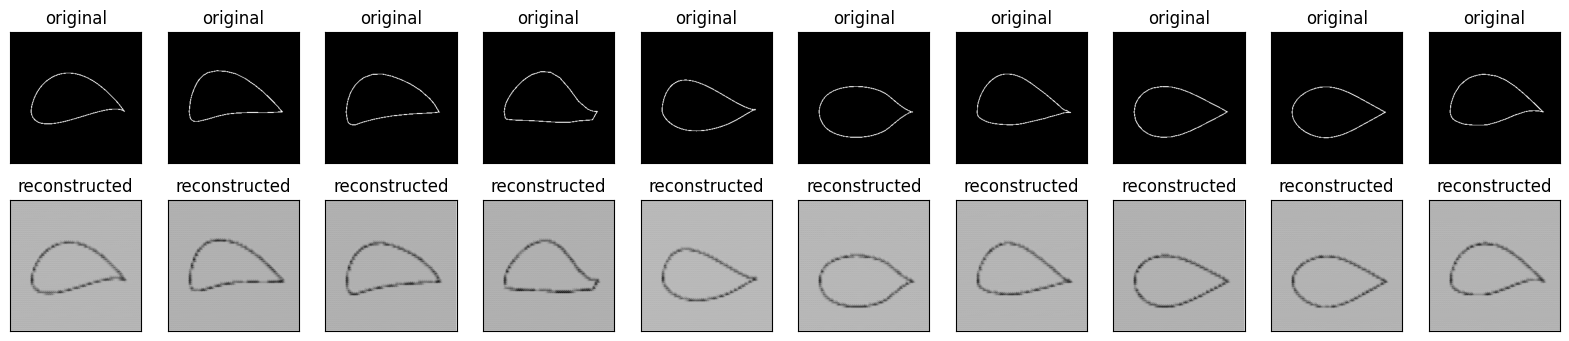

In [77]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(x_test[i])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(decoded_imgs[i])
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.savefig('airfoils_compare/compare2.png', pad_inches=0)
plt.show()
